In [1]:
import pickle
with open("best50_10each_notInterpol.pkl", "rb") as f:
    lc = pickle.load(f)

<IPython.core.display.Javascript object>


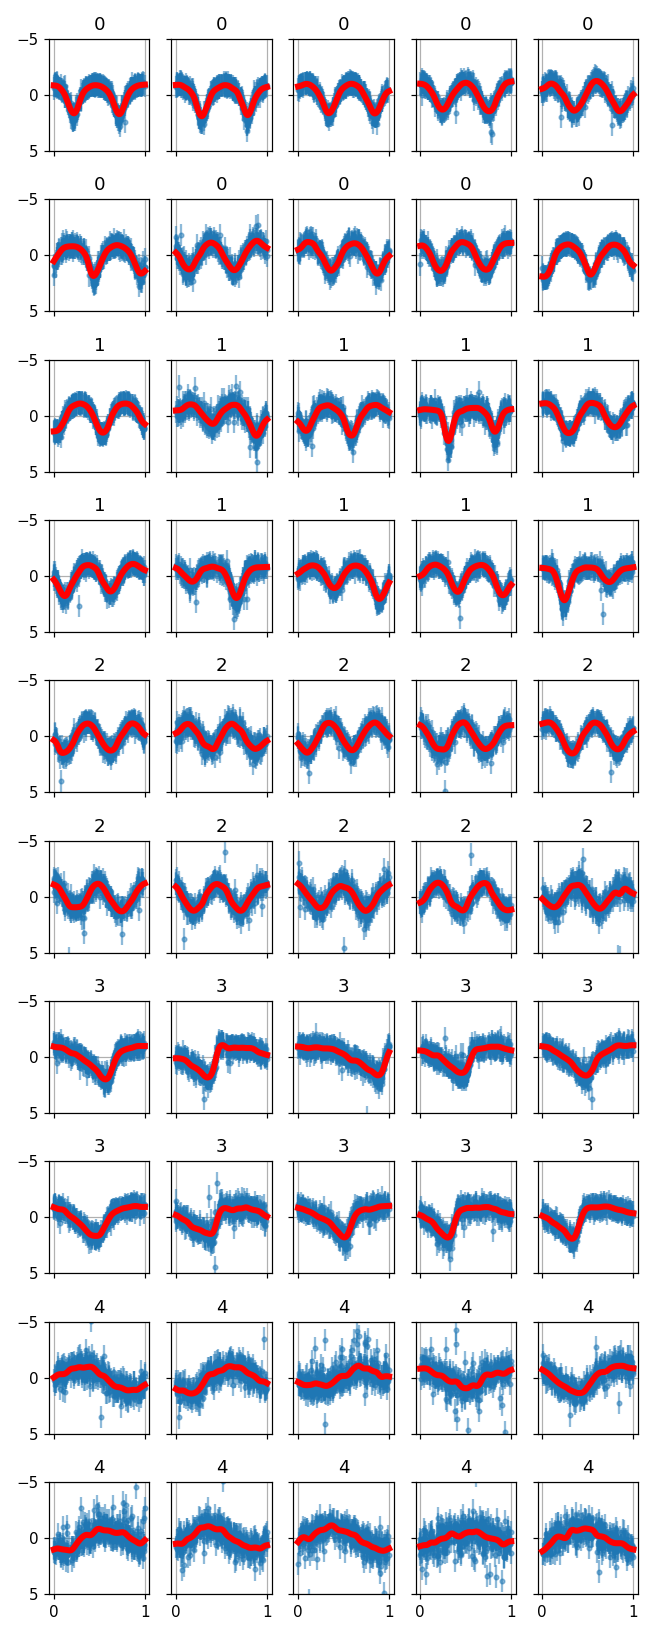

In [3]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(10, 5, tight_layout=True, figsize=(6, 15), 
                       sharex=True, sharey=True)
ax[0, 0].invert_yaxis()
ax[0, 0].set_ylim([5, -5])
window = lambda phi_point, phi : np.exp(-0.5*(phi_point-phi)**2/0.03**2)
phi_interp = np.linspace(0, 1, num=100)

data = []
labels = []
for i, ax_ in enumerate(ax.ravel()):
    phi, mag, err = lc[i]['data'].detach().numpy()
    mask = ~(mag == 0.0)
    phi = phi[mask]
    mag = mag[mask]
    err = err[mask]
    ax_.errorbar(phi, mag, err, fmt='.', alpha=0.5)
    mag_interp = np.array([np.sum(window(p, phi)*mag)/np.sum(window(p, phi)) for p in phi_interp])
    if lc[i]['label'].item() == 0 or lc[i]['label'].item() == 3:
        data.append(mag_interp)
        if lc[i]['label'].item() == 3:
            labels.append(1)
        else:
            labels.append(lc[i]['label'].item())
    ax_.plot(phi_interp, mag_interp, 'r-', lw=4, zorder=100)
    ax_.grid()
    ax_.set_title(lc[i]['label'].item())

In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader

data_torch = TensorDataset(torch.from_numpy(np.array(data).astype('float32')),
                           torch.from_numpy(np.array(labels).astype('float32')))
loader = DataLoader(data_torch, batch_size=4)

class Example(torch.nn.Module):
    def __init__(self, n_channels=32, n_linear=8):
        super(Example, self).__init__()
        self.conv1 = torch.nn.Conv1d(in_channels=1, out_channels=n_channels, stride=2, kernel_size=3)
        self.conv2 = torch.nn.Conv1d(in_channels=n_channels, out_channels=n_channels, stride=2, kernel_size=3)
        self.conv3 = torch.nn.Conv1d(in_channels=n_channels, out_channels=n_channels, stride=2, kernel_size=3)
        self.gpool = torch.nn.AvgPool1d(kernel_size=11)
        self.linear1 = torch.nn.Linear(in_features=n_channels, out_features=n_linear)
        self.linear2 = torch.nn.Linear(in_features=n_linear, out_features=1)
        self.activation = torch.nn.ReLU()
        
    def forward(self, x):
        h = self.activation(self.conv1(x))
        h = self.activation(self.conv2(h))
        h = self.activation(self.conv3(h))
        #print(h.shape)
        h = self.gpool(h)
        h = h.view(-1, 32)
        h = self.activation(self.linear1(h))
        return self.linear2(h)

In [19]:
model = Example()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')
track_loss = []
for epoch in range(200):
    epoch_loss = 0.0
    for x, y in loader:
        optimizer.zero_grad()
        haty = model.forward(x.unsqueeze(1))
        loss = criterion(haty, y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    track_loss.append(epoch_loss)

<IPython.core.display.Javascript object>


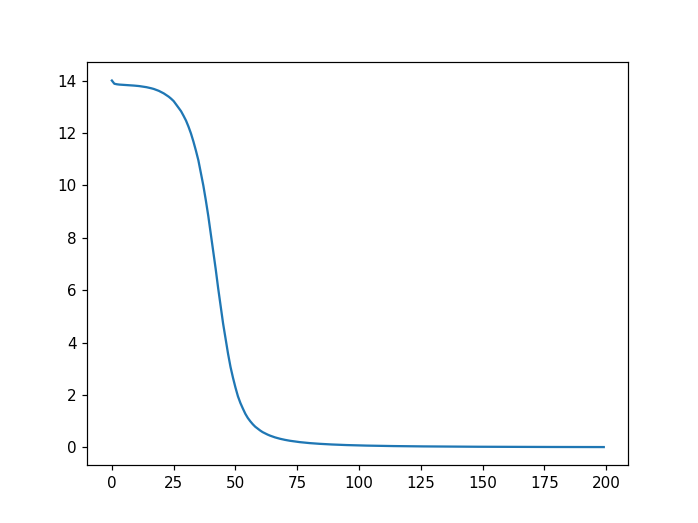

tensor([8.1495e-06, 6.6057e-07, 7.5676e-05, 5.1157e-04, 2.2821e-04, 2.5745e-06,
        8.4404e-04, 1.7713e-05, 2.6911e-05, 2.9708e-03, 9.9983e-01, 9.9994e-01,
        9.9989e-01, 9.9870e-01, 9.9901e-01, 9.9946e-01, 9.9965e-01, 9.9904e-01,
        9.9909e-01, 9.9993e-01])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])

In [20]:
plt.figure()
plt.plot(track_loss)
result = torch.nn.Sigmoid()(model.forward(data_torch.tensors[0].unsqueeze(1))).detach().squeeze(1)
#result = np.argmax((model.forward(data_torch.tensors[0].unsqueeze(1))).detach().squeeze(1))

display(result, 
        data_torch.tensors[1])